# Notebook for finding annual mean HAIL_MAX2D

### Import necessary libraries (xarray for resampling, cartopy for plotting)

In [1]:
import numpy as np
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

## Open daily HIST WRF dataset (resampled to convective daily max)

In [2]:
hist_daily_max = xr.open_dataset('/home/scratch/jgoodin/hist_daily_max_hail_inches.nc') #Open .nc file saved to scratch directory

In [4]:
hist_daily_max #Should return daily values for 15 years (make sure first time stamp starts at T12)

<xarray.Dataset>
Dimensions:     (Time: 5479, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 1990-09-30T12:00:00 ... 2005-09-29T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) float32 ...

## Resample by year and sum along 'Time' dimension- provides sum of all max values of HAIL_MAX2D for each grid cell. Then take mean along 'year' dimension to provide annual mean values of max HAIL_MAX2D

In [34]:
mean_annual_hailmax = hist_daily_max.groupby('Time.year').sum(dim = 'Time').mean(dim = 'year') #Groupby year and take mean to find mean values of max HAIL_MAX2D

In [38]:
mean_annual_hailmax #Print out resampled dataset- should be 2D

<xarray.Dataset>
Dimensions:     (south_north: 899, west_east: 1399)
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (south_north, west_east) float32 nan nan nan nan ... nan nan nan

## Select values ≥ 1 in

In [39]:
mean_annual_hailmax = mean_annual_hailmax.where(mean_annual_hailmax >= 1) #Select only values that are ≥ 1 in **This is the plotting variable**

### Select HAIL_MAX2D variable from above dataset(s) to create a plottable data array

In [40]:
mean_annual_hailmax = mean_annual_hailmax.HAIL_MAX2D

### Import netcdf file containing lat/lon coords for WRF files (use this for plotting later)

In [22]:
coords = xr.open_dataset('lat_lon.nc') #Open .nc file containing WRF lat/lon coords

### Assign lat/lon coords from file to variables

In [23]:
lats = coords.CLAT.values[0, :, :]
lons = coords.CLONG.values[0, :, :]

## Plot data on map of CONUS

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


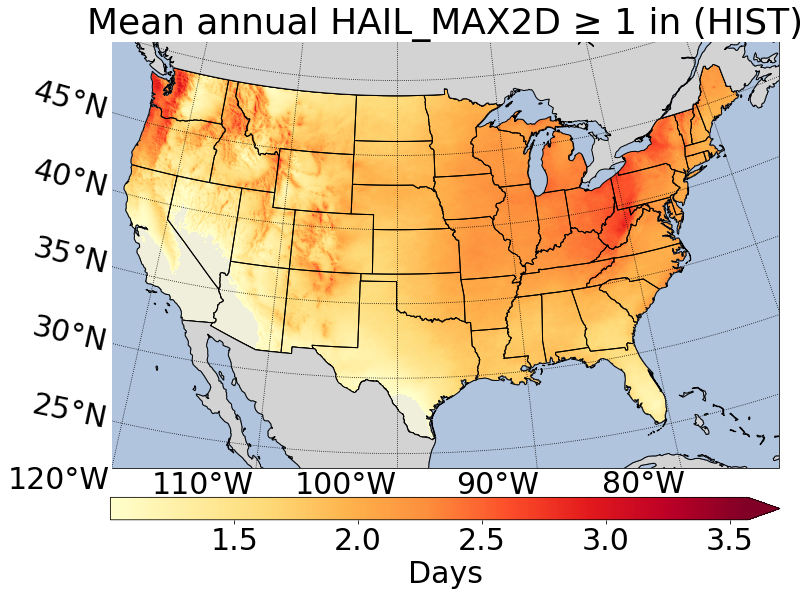

In [41]:
fig = plt.figure(figsize= (12,8)) #Plot a figure
gs1 = gridspec.GridSpec(2, 1, height_ratios=[1, .05], bottom=.05, top=.95, wspace=.1)
map_proj = ccrs.LambertConformal(central_longitude = -100, central_latitude = 35) #Set projection, central lat/lon
ax = plt.subplot(projection = map_proj)
#ax.set_title('Maximum diameter hail for 2005', fontsize = 22)
ax.add_feature(cfeature.LAND.with_scale('10m')) #Add land
countries_shp = shpreader.natural_earth(resolution='50m',
                                     category='cultural',
                                     name='admin_0_countries')
for country, info in zip(shpreader.Reader(countries_shp).geometries(), 
                             shpreader.Reader(countries_shp).records()):
        if info.attributes['NAME_LONG'] != 'United States':

            ax.add_geometries([country], ccrs.PlateCarree(),
                             facecolor='lightgrey', edgecolor='k', zorder=6)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='k', 
                                                facecolor='None'), zorder=8) 
ax.add_feature(cfeature.BORDERS.with_scale('10m')) #Add state borders
ax.add_feature(cfeature.STATES.with_scale('10m'), facecolor = 'none') #Add US states
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', 
                                                facecolor='lightsteelblue'), zorder=6)
lakes_shp = shpreader.natural_earth(resolution='50m',
                                     category='physical',
                                     name='lakes')
for lake, info in zip(shpreader.Reader(lakes_shp).geometries(), 
                             shpreader.Reader(lakes_shp).records()):
        name = info.attributes['name']
        if name == 'Lake Superior' or name == 'Lake Michigan' or \
           name == 'Lake Huron' or name == 'Lake Erie' or name == 'Lake Ontario':
            
            ax.add_geometries([lake], ccrs.PlateCarree(),
                             facecolor='lightsteelblue', edgecolor='k', zorder=6)
ax.set_extent([240,287,22,50]) #Set lat/lon boundaries
lrFig = ax.pcolormesh(lons, lats, mean_annual_hailmax, cmap = 'YlOrRd', transform = ccrs.PlateCarree())
gls = ax.gridlines(draw_labels=True, dms = True, x_inline=False, y_inline=False, color="black", linestyle="dotted", zorder = 10)
gls.top_labels=False
gls.right_labels=False
gls.xlabel_style = {'size': 30, 'rotation': 0}
gls.xpadding = 12.0
gls.ylabel_style = {'size': 30}
plt.title("Mean annual HAIL_MAX2D ≥ 1 in (HIST)", fontsize = 36)
ax1 = plt.subplot(gs1[1, 0])
cb = plt.colorbar(lrFig, cax = ax1, orientation = 'horizontal', extend = 'max')
cb.set_label('Days', fontsize = 30)
cb.ax.tick_params(labelsize = 30)
plt.subplots_adjust(bottom=0.14)
#plt.savefig('/home/scratch/jgoodin/annual_mesh_climos/hist_mean_annual_max_hail.png') #**Make sure to save results to png!**